<a href="https://colab.research.google.com/github/teacherSsamko/DL-study/blob/main/w1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [1주차] 심화과제: MNIST 예측 모델에 deep learning techniques 적용하기

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

## [MY CODE] 구글 드라이브 마운트

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## [MY CODE] 체크포인트 저장 함수

In [3]:
def save_checkpoint(model, optimizer, epoch, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

In [4]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


## [MY CODE] 3채널 이미지 확인

CIFAR10 이미지는 (channel, height, width) 형식인데 반해, plt.imshow는 (height, width, channel)을 인자로 받기 때문에, permute를 이용해서 순서를 재배열

50000
torch.Size([3, 32, 32]) 6


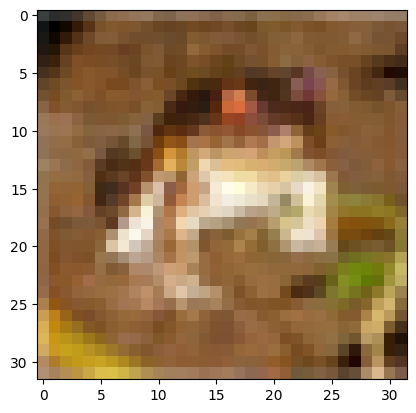

In [ ]:
print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0].permute(1, 2, 0))

In [5]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

In [6]:
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified


In [7]:
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
)

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


## [LOG] shape 확인

In [9]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x


adam_model = Model(32 * 32 * 3, 1024)
sgd_model = Model(32 * 32 * 3, 1024)

## [FEEDBACK] 왜 여기선 LeackyReLU를 쓰나요?

leackyReLU가 음수를 0으로 만들지 않아서, 음수에 대해서도 학습이 가능하다는 것은 알겠는데, 여기서는 왜 음수에 대해서 학습하는 것이 중요한지 모르겠습니다.

## [MY CODE] Adam optimizer 사용

In [10]:
from torch.optim import Adam, SGD


lr = 0.001
adam_model = adam_model.to('cuda')
sgd_model = sgd_model.to('cuda')

sgd_optimizer = SGD(sgd_model.parameters(), lr=lr)
adam_optimizer = Adam(adam_model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

In [11]:
def accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    cnt = 0
    acc = 0

    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)
      preds = torch.argmax(preds, dim=1)

      cnt += labels.shape[0]
      acc += (preds == labels).sum().item()

    return acc / cnt

## [MY CODE] Adam 학습 및 정확도 계산

In [ ]:
n_epochs = 50
adam_train_acc_list = []
sgd_train_acc_list = []

for epoch in range(n_epochs):
  adam_total_loss = 0
  sgd_total_loss = 0

  for data in trainloader:
    adam_model.zero_grad()
    sgd_model.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    adam_preds = adam_model(inputs)
    adam_loss = criterion(adam_preds, labels)
    adam_loss.backward()
    adam_optimizer.step()

    adam_total_loss += adam_loss.item()

    sgd_preds = sgd_model(inputs)
    sgd_loss = criterion(sgd_preds, labels)
    sgd_loss.backward()
    sgd_optimizer.step()

    sgd_total_loss += sgd_loss.item()


  # Append Accuracies
  adam_train_acc_list.append(accuracy(adam_model, trainloader))
  sgd_train_acc_list.append(accuracy(sgd_model, testloader))


  if epoch % 10 == 0:
    print(f"[Adam] Epoch {epoch:3d} | Loss: {adam_total_loss:.3f}")
    print(f"[SGD] Epoch {epoch:3d} | Loss: {sgd_total_loss:.3f}")

[Adam] Epoch   0 | Loss: 366.789
[SGD] Epoch   0 | Loss: 450.463
[Adam] Epoch  10 | Loss: 245.610
[SGD] Epoch  10 | Loss: 428.747
[Adam] Epoch  20 | Loss: 193.546
[SGD] Epoch  20 | Loss: 402.508
[Adam] Epoch  30 | Loss: 142.442
[SGD] Epoch  30 | Loss: 386.583
[Adam] Epoch  40 | Loss: 96.571
[SGD] Epoch  40 | Loss: 376.541


## [LOG] 학습 과정에서 Epoch별 손실값 출력

In [16]:
def plot_acc(accs1, accs2, label1='sgd', label2='adam', title=None):
  x = np.arange(len(accs1))

  plt.plot(x, accs1, label=label1)
  plt.plot(x, accs2, label=label2)
  plt.legend()
  if title:
    plt.title(title)
  plt.show()

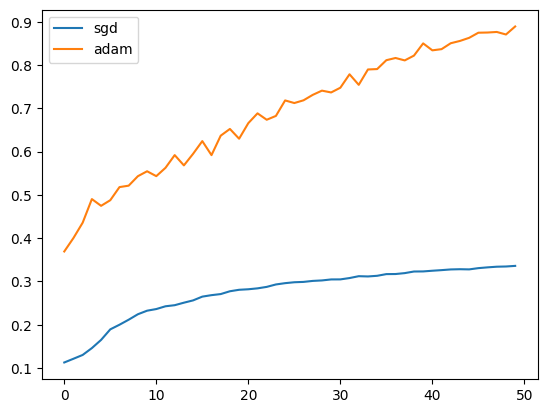

In [ ]:
plot_acc(sgd_train_acc_list, adam_train_acc_list)

## [LOG] Epoch별 정확도 그래프

## [MY CODE] Sigmoid를 사용한 모델

In [ ]:
from torch import nn


class SigmoidModel(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x


adam_sigmoid_model = SigmoidModel(32 * 32 * 3, 1024)
adam_sigmoid_model = adam_sigmoid_model.to('cuda')
adam_sigmoid_optimizer = Adam(adam_sigmoid_model.parameters(), lr=lr)

In [ ]:
n_epochs = 50
adam_sigmoid_train_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0

  for data in trainloader:
    adam_sigmoid_model.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = adam_sigmoid_model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    adam_sigmoid_optimizer.step()

    total_loss += loss.item()


  # Append Accuracies
  adam_sigmoid_train_acc_list.append(accuracy(adam_sigmoid_model, trainloader))


  if epoch % 10 == 0:
    print(f"[Adam-Sigmoid] Epoch {epoch:3d} | Loss: {total_loss:.3f}")

[Adam-Sigmoid] Epoch   0 | Loss: 391.019
[Adam-Sigmoid] Epoch  10 | Loss: 265.178
[Adam-Sigmoid] Epoch  20 | Loss: 233.331
[Adam-Sigmoid] Epoch  30 | Loss: 200.060
[Adam-Sigmoid] Epoch  40 | Loss: 175.787


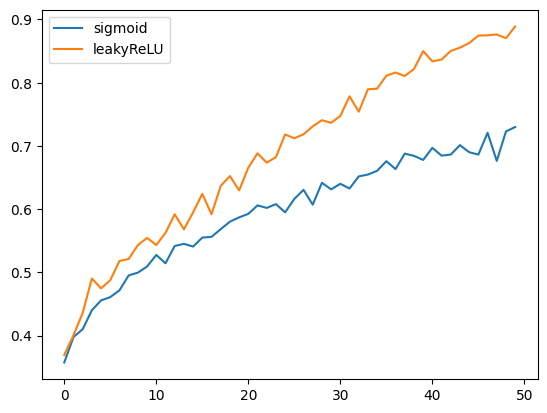

In [ ]:
plot_acc(adam_sigmoid_train_acc_list, adam_train_acc_list, label1="sigmoid", label2="leakyReLU")

## [LOG] sigmoid와 leakyReLU의 train 정확도

## [FEEDBACK] leakyReLU가 sigmoid보다 결과가 좋은 이유

leakyReLU가 결과가 좋을 것이라는 걸 학습 전에 미리 예측할 수 있는 근거가 있을까요?
아니면 직접 해봐야만 알 수 있는거고, 결과를 그냥 받아들이면 되는건가요?

## [MY CODE] Droupout 적용

In [13]:
from torch import nn
from torch.optim import Adam

lr = 0.001


class DropoutModel(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, n_dim)
    self.layer4 = nn.Linear(n_dim, n_dim)
    self.layer5 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.dropout(x)
    x = self.act(self.layer2(x))
    x = self.dropout(x)
    x = self.act(self.layer3(x))
    x = self.dropout(x)
    x = self.act(self.layer4(x))
    x = self.dropout(x)
    x = self.layer5(x)

    return x


dropout_model = DropoutModel(32 * 32 * 3, 1024)
dropout_model = dropout_model.to('cuda')
dropout_optimizer = Adam(dropout_model.parameters(), lr=lr)

In [14]:
n_epochs = 100
dropout_train_acc_list = []
dropout_test_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0
  dropout_model.train()

  for data in trainloader:
    dropout_model.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = dropout_model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    dropout_optimizer.step()

    total_loss += loss.item()


  # Append Accuracies
  dropout_train_acc_list.append(accuracy(dropout_model, trainloader))
  dropout_test_acc_list.append(accuracy(dropout_model, testloader))


  if epoch % 10 == 0:
    print(f"[Dropout] Epoch {epoch:3d} | Loss: {total_loss:.3f}")
    checkpoint_path = f'/content/drive/My Drive/Colab Notebooks/HH_w1/dropout_checkpoint_{epoch}.pth'
    save_checkpoint(dropout_model, dropout_optimizer, epoch, checkpoint_path)


[Dropout] Epoch   0 | Loss: 381.230
[Dropout] Epoch  10 | Loss: 272.403
[Dropout] Epoch  20 | Loss: 233.538
[Dropout] Epoch  30 | Loss: 195.940
[Dropout] Epoch  40 | Loss: 166.523
[Dropout] Epoch  50 | Loss: 143.427
[Dropout] Epoch  60 | Loss: 124.279
[Dropout] Epoch  70 | Loss: 111.846
[Dropout] Epoch  80 | Loss: 103.007
[Dropout] Epoch  90 | Loss: 97.606


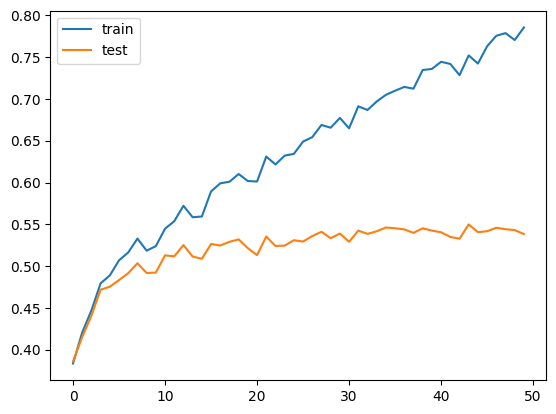

In [ ]:
plot_acc(dropout_train_acc_list, dropout_test_acc_list, label1="train", label2="test")

## [LOG] layer 3개, epoch 50으로 학습한 결과

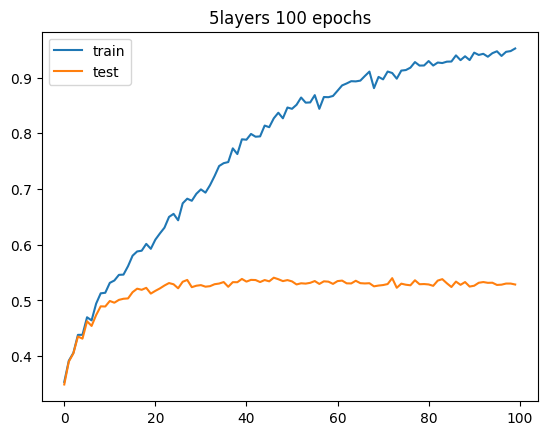

In [17]:
plot_acc(
    dropout_train_acc_list,
    dropout_test_acc_list,
    label1="train",
    label2="test",
    title="5layers 100 epochs",
)

## [LOG] 20 epoch정도부터 과적합

[MY CODE] dropout rate 조정

In [18]:
from torch import nn
from torch.optim import Adam

lr = 0.001


class DropoutModel(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, n_dim)
    self.layer4 = nn.Linear(n_dim, n_dim)
    self.layer5 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.dropout(x)
    x = self.act(self.layer2(x))
    x = self.dropout(x)
    x = self.act(self.layer3(x))
    x = self.dropout(x)
    x = self.act(self.layer4(x))
    x = self.dropout(x)
    x = self.layer5(x)

    return x


dropout_model = DropoutModel(32 * 32 * 3, 1024)
dropout_model = dropout_model.to('cuda')
dropout_optimizer = Adam(dropout_model.parameters(), lr=lr)

## [MY CODE] validation set

In [19]:
from torch.utils.data import random_split

train_size = int(0.8 * len(trainset))
valid_size = len(trainset) - train_size
train_dataset, valid_dataset = random_split(trainset, [train_size, valid_size])

validloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size,
)

## [MY CODE] early stop 적용

In [20]:
import copy

n_epochs = 100
dropout_train_acc_list = []
dropout_test_acc_list = []

# Early Stop
best_valid_acc = 0.0
patience = 10
epochs_without_improvement = 0

for epoch in range(n_epochs):
  total_loss = 0
  dropout_model.train()

  for data in trainloader:
    dropout_model.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = dropout_model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    dropout_optimizer.step()

    total_loss += loss.item()

  valid_acc = accuracy(dropout_model, validloader)

  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    best_model_wts = copy.deepcopy(dropout_model.state_dict())
    epochs_without_improvement = 0
  else:
    epochs_without_improvement += 1

  if epochs_without_improvement >= patience:
    print(f"Early stopping at epoch {epoch}.")
    break

  # Append Accuracies
  dropout_train_acc_list.append(accuracy(dropout_model, trainloader))
  dropout_test_acc_list.append(accuracy(dropout_model, testloader))


  if epoch % 10 == 0:
    print(f"[Dropout] Epoch {epoch:3d} | Loss: {total_loss:.3f}")
    checkpoint_path = f'/content/drive/My Drive/Colab Notebooks/HH_w1/dropout_checkpoint_{epoch}.pth'
    save_checkpoint(dropout_model, dropout_optimizer, epoch, checkpoint_path)


dropout_model.load_state_dict(best_model_wts)

[Dropout] Epoch   0 | Loss: 388.374
[Dropout] Epoch  10 | Loss: 292.269
[Dropout] Epoch  20 | Loss: 266.684
[Dropout] Epoch  30 | Loss: 248.682
[Dropout] Epoch  40 | Loss: 237.013
[Dropout] Epoch  50 | Loss: 225.494
[Dropout] Epoch  60 | Loss: 213.209
[Dropout] Epoch  70 | Loss: 203.741
[Dropout] Epoch  80 | Loss: 195.568
[Dropout] Epoch  90 | Loss: 185.824


<All keys matched successfully>

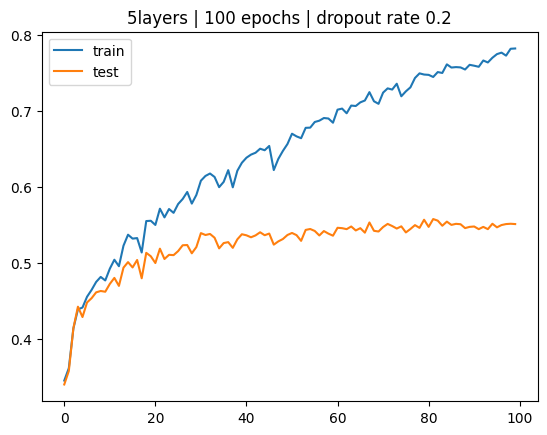

In [21]:
plot_acc(
    dropout_train_acc_list,
    dropout_test_acc_list,
    label1="train",
    label2="test",
    title="5layers | 100 epochs | dropout rate 0.2",
)

## [LOG] train은 소폭 감소 test는 소폭 증가

## [MY CODE] neuron 개수 조정

1024 > 512

In [22]:
from torch import nn
from torch.optim import Adam

lr = 0.001


class DropoutModel(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, n_dim)
    self.layer4 = nn.Linear(n_dim, n_dim)
    self.layer5 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.dropout(x)
    x = self.act(self.layer2(x))
    x = self.dropout(x)
    x = self.act(self.layer3(x))
    x = self.dropout(x)
    x = self.act(self.layer4(x))
    x = self.dropout(x)
    x = self.layer5(x)

    return x


dropout_model = DropoutModel(32 * 32 * 3, 512)
dropout_model = dropout_model.to('cuda')
dropout_optimizer = Adam(dropout_model.parameters(), lr=lr)

In [23]:
import copy

n_epochs = 100
dropout_train_acc_list = []
dropout_test_acc_list = []

# Early Stop
best_valid_acc = 0.0
patience = 10
epochs_without_improvement = 0

for epoch in range(n_epochs):
  total_loss = 0
  dropout_model.train()

  for data in trainloader:
    dropout_model.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = dropout_model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    dropout_optimizer.step()

    total_loss += loss.item()

  valid_acc = accuracy(dropout_model, validloader)

  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    best_model_wts = copy.deepcopy(dropout_model.state_dict())
    epochs_without_improvement = 0
  else:
    epochs_without_improvement += 1

  if epochs_without_improvement >= patience:
    print(f"Early stopping at epoch {epoch}.")
    break

  # Append Accuracies
  dropout_train_acc_list.append(accuracy(dropout_model, trainloader))
  dropout_test_acc_list.append(accuracy(dropout_model, testloader))


  if epoch % 10 == 0:
    print(f"[Dropout] Epoch {epoch:3d} | Loss: {total_loss:.3f}")
    checkpoint_path = f'/content/drive/My Drive/Colab Notebooks/HH_w1/dropout_checkpoint_{epoch}.pth'
    save_checkpoint(dropout_model, dropout_optimizer, epoch, checkpoint_path)


dropout_model.load_state_dict(best_model_wts)

[Dropout] Epoch   0 | Loss: 378.392
[Dropout] Epoch  10 | Loss: 275.945
[Dropout] Epoch  20 | Loss: 240.466
[Dropout] Epoch  30 | Loss: 211.389
[Dropout] Epoch  40 | Loss: 185.686
[Dropout] Epoch  50 | Loss: 166.212
[Dropout] Epoch  60 | Loss: 151.231
[Dropout] Epoch  70 | Loss: 141.969
[Dropout] Epoch  80 | Loss: 130.818
[Dropout] Epoch  90 | Loss: 124.057


<All keys matched successfully>

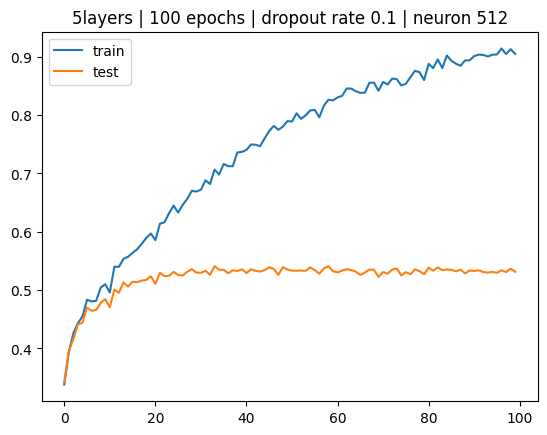

In [26]:
plot_acc(
    dropout_train_acc_list,
    dropout_test_acc_list,
    label1="train",
    label2="test",
    title="5layers | 100 epochs | dropout rate 0.1 | neuron 512",
)

## [MY CODE] CNN 사용

In [27]:
import torch.nn as nn

lr = 0.001

class CNNModel(nn.Module):
    def __init__(self, n_dim):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, n_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_dim, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.act = nn.LeakyReLU()

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x

cnn_model = CNNModel(32)
cnn_model = cnn_model.to('cuda')
cnn_optimizer = Adam(cnn_model.parameters(), lr=lr)

In [28]:
import copy

n_epochs = 100
train_acc_list = []
test_acc_list = []

# Early Stop
best_valid_acc = 0.0
patience = 10
epochs_without_improvement = 0

for epoch in range(n_epochs):
  total_loss = 0
  cnn_model.train()

  for data in trainloader:
    cnn_model.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = cnn_model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    cnn_optimizer.step()

    total_loss += loss.item()

  valid_acc = accuracy(cnn_model, validloader)

  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    best_model_wts = copy.deepcopy(cnn_model.state_dict())
    epochs_without_improvement = 0
  else:
    epochs_without_improvement += 1

  if epochs_without_improvement >= patience:
    print(f"Early stopping at epoch {epoch}.")
    break

  # Append Accuracies
  train_acc_list.append(accuracy(cnn_model, trainloader))
  test_acc_list.append(accuracy(cnn_model, testloader))


  if epoch % 10 == 0:
    print(f"[CNN] Epoch {epoch:3d} | Loss: {total_loss:.3f}")
    checkpoint_path = f'/content/drive/My Drive/Colab Notebooks/HH_w1/cnn_checkpoint_{epoch}.pth'
    save_checkpoint(cnn_model, cnn_optimizer, epoch, checkpoint_path)


cnn_model.load_state_dict(best_model_wts)

[CNN] Epoch   0 | Loss: 313.551
[CNN] Epoch  10 | Loss: 119.346
[CNN] Epoch  20 | Loss: 38.870
[CNN] Epoch  30 | Loss: 9.507
[CNN] Epoch  40 | Loss: 0.448
Early stopping at epoch 50.


<All keys matched successfully>

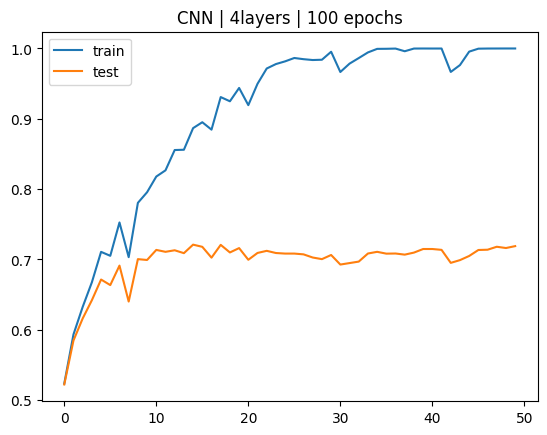

In [31]:
plot_acc(
    train_acc_list,
    test_acc_list,
    label1="train",
    label2="test",
    title="CNN | 4layers | 100 epochs",
)

## [LOG] 정확도가 올라오긴 했으나 여전히 과적합을 보임

## [MY CODE] Dropout 적용

In [32]:
import torch.nn as nn

lr = 0.001

class CNNModel(nn.Module):
    def __init__(self, n_dim):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, n_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_dim, n_dim * 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(n_dim * 2 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.act = nn.LeakyReLU()

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(self.act(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

cnn_model = CNNModel(32)
cnn_model = cnn_model.to('cuda')
cnn_optimizer = Adam(cnn_model.parameters(), lr=lr)

In [33]:
import copy

n_epochs = 100
train_acc_list = []
test_acc_list = []

# Early Stop
best_valid_acc = 0.0
patience = 10
epochs_without_improvement = 0

for epoch in range(n_epochs):
  total_loss = 0
  cnn_model.train()

  for data in trainloader:
    cnn_model.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = cnn_model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    cnn_optimizer.step()

    total_loss += loss.item()

  valid_acc = accuracy(cnn_model, validloader)

  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    best_model_wts = copy.deepcopy(cnn_model.state_dict())
    epochs_without_improvement = 0
  else:
    epochs_without_improvement += 1

  if epochs_without_improvement >= patience:
    print(f"Early stopping at epoch {epoch}.")
    break

  # Append Accuracies
  train_acc_list.append(accuracy(cnn_model, trainloader))
  test_acc_list.append(accuracy(cnn_model, testloader))


  if epoch % 10 == 0:
    print(f"[CNN] Epoch {epoch:3d} | Loss: {total_loss:.3f}")
    checkpoint_path = f'/content/drive/My Drive/Colab Notebooks/HH_w1/cnn_checkpoint_{epoch}.pth'
    save_checkpoint(cnn_model, cnn_optimizer, epoch, checkpoint_path)


cnn_model.load_state_dict(best_model_wts)

[CNN] Epoch   0 | Loss: 339.281
[CNN] Epoch  10 | Loss: 155.906
[CNN] Epoch  20 | Loss: 105.953
[CNN] Epoch  30 | Loss: 76.629
[CNN] Epoch  40 | Loss: 60.797
[CNN] Epoch  50 | Loss: 50.945
[CNN] Epoch  60 | Loss: 43.909
[CNN] Epoch  70 | Loss: 40.613
Early stopping at epoch 75.


<All keys matched successfully>

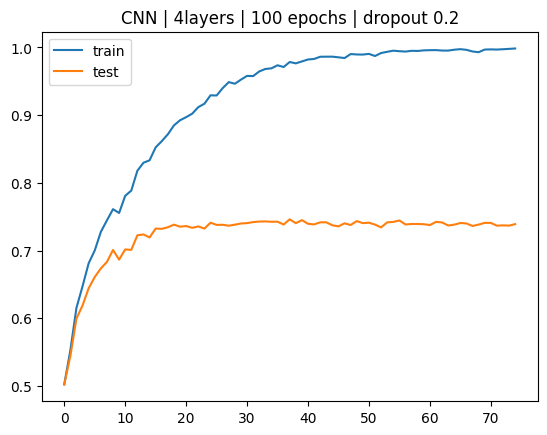

In [34]:
plot_acc(
    train_acc_list,
    test_acc_list,
    label1="train",
    label2="test",
    title="CNN | 4layers | 100 epochs | dropout 0.2",
)

## [MY CODE] 데이터 증강 & 정규화

In [35]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train,
)

Files already downloaded and verified


In [36]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

In [37]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

Files already downloaded and verified


In [38]:
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [39]:
import torch.nn as nn

lr = 0.001

class CNNModel(nn.Module):
    def __init__(self, n_dim):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, n_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_dim, n_dim * 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(n_dim * 2 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.act = nn.LeakyReLU()

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(self.act(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

cnn_model = CNNModel(32)
cnn_model = cnn_model.to('cuda')
cnn_optimizer = Adam(cnn_model.parameters(), lr=lr)

In [40]:
import copy

n_epochs = 100
train_acc_list = []
test_acc_list = []

# Early Stop
best_valid_acc = 0.0
patience = 10
epochs_without_improvement = 0

for epoch in range(n_epochs):
  total_loss = 0
  cnn_model.train()

  for data in trainloader:
    cnn_model.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = cnn_model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    cnn_optimizer.step()

    total_loss += loss.item()

  valid_acc = accuracy(cnn_model, validloader)

  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    best_model_wts = copy.deepcopy(cnn_model.state_dict())
    epochs_without_improvement = 0
  else:
    epochs_without_improvement += 1

  if epochs_without_improvement >= patience:
    print(f"Early stopping at epoch {epoch}.")
    break

  # Append Accuracies
  train_acc_list.append(accuracy(cnn_model, trainloader))
  test_acc_list.append(accuracy(cnn_model, testloader))


  if epoch % 10 == 0:
    print(f"[CNN] Epoch {epoch:3d} | Loss: {total_loss:.3f}")
    checkpoint_path = f'/content/drive/My Drive/Colab Notebooks/HH_w1/cnn_checkpoint_{epoch}.pth'
    save_checkpoint(cnn_model, cnn_optimizer, epoch, checkpoint_path)


cnn_model.load_state_dict(best_model_wts)

[CNN] Epoch   0 | Loss: 344.966
[CNN] Epoch  10 | Loss: 196.920
[CNN] Epoch  20 | Loss: 168.210
[CNN] Epoch  30 | Loss: 153.689
Early stopping at epoch 33.


<All keys matched successfully>

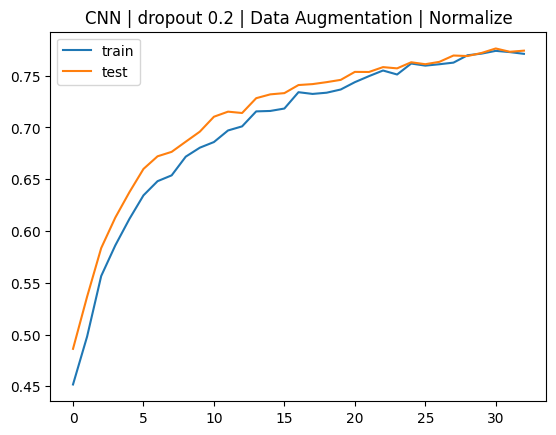

In [41]:
plot_acc(
    train_acc_list,
    test_acc_list,
    label1="train",
    label2="test",
    title="CNN | dropout 0.2 | Data Augmentation | Normalize",
)

## [LOG] 데이터 증강 및 정규화 후 과적합 해소

## [MY CODE] patience 증가

local optimum에 빠진게 아닌가 싶어서, patience 20으로 설정

In [42]:
import copy

n_epochs = 100
train_acc_list = []
test_acc_list = []

# Early Stop
best_valid_acc = 0.0
patience = 20
epochs_without_improvement = 0

for epoch in range(n_epochs):
  total_loss = 0
  cnn_model.train()

  for data in trainloader:
    cnn_model.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = cnn_model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    cnn_optimizer.step()

    total_loss += loss.item()

  valid_acc = accuracy(cnn_model, validloader)

  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    best_model_wts = copy.deepcopy(cnn_model.state_dict())
    epochs_without_improvement = 0
  else:
    epochs_without_improvement += 1

  if epochs_without_improvement >= patience:
    print(f"Early stopping at epoch {epoch}.")
    break

  # Append Accuracies
  train_acc_list.append(accuracy(cnn_model, trainloader))
  test_acc_list.append(accuracy(cnn_model, testloader))


  if epoch % 10 == 0:
    print(f"[CNN] Epoch {epoch:3d} | Loss: {total_loss:.3f}")
    checkpoint_path = f'/content/drive/My Drive/Colab Notebooks/HH_w1/cnn_checkpoint_{epoch}.pth'
    save_checkpoint(cnn_model, cnn_optimizer, epoch, checkpoint_path)


cnn_model.load_state_dict(best_model_wts)

[CNN] Epoch   0 | Loss: 161.430
[CNN] Epoch  10 | Loss: 150.461
[CNN] Epoch  20 | Loss: 142.266
[CNN] Epoch  30 | Loss: 137.819
[CNN] Epoch  40 | Loss: 133.188
[CNN] Epoch  50 | Loss: 129.887
[CNN] Epoch  60 | Loss: 127.208
Early stopping at epoch 70.


<All keys matched successfully>

## [LOG] optimizer 연속 사용

목적이 local optimum 탈출이기때문에 optimizer를 초기화 하지 않고, 이어서 학습 진행

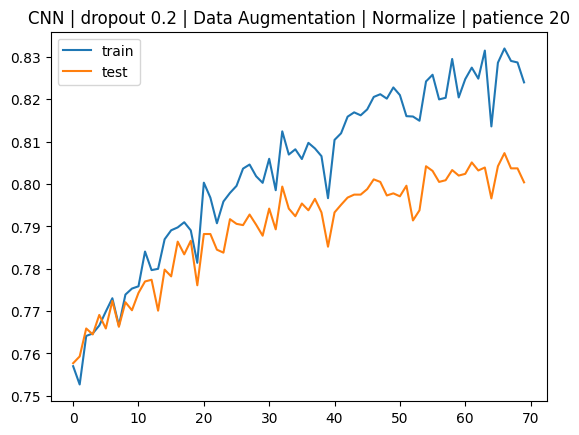

In [43]:
plot_acc(
    train_acc_list,
    test_acc_list,
    label1="train",
    label2="test",
    title="CNN | dropout 0.2 | Data Augmentation | Normalize | patience 20",
)

## [LOG] 결과는 좋아졌으나 과적합 발생

## [FEEDBACK] patience를 늘렸을 뿐인데 과적합이 발생한 이유는?

epoch가 늘어나서(이전 학습+이번 학습) 일까요?

